In [23]:
# -------------------- IMPORTS --------------------
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
import math

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.decomposition import PCA

from scipy import stats
from scipy.signal import welch

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [24]:
# -------------------- SETTINGS --------------------
plt.style.use('seaborn-v0_8')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Directories
DATA_ROOT = Path("./IMS_Bearing_Dataset")   # Place your folders here (1st_test, 2nd_test, 3rd_test)
RESULTS_DIR = Path("./results")
MODELS_DIR = Path("./models")
PLOTS_DIR = Path("./plots")

# Pipeline constants
TRAIN_FRACTION = 0.7
LABEL_METHOD = "last_fraction"
LABEL_FRACTION = 0.1
SAMPLE_RATE = 20000  # Hz

In [25]:
# -------------------- UTILITY FUNCTIONS --------------------
def ensure_dirs():
    """Create output directories if they don't exist."""
    for d in [RESULTS_DIR, MODELS_DIR, PLOTS_DIR]:
        d.mkdir(exist_ok=True, parents=True)

def safe_savefig(path):
    """Save plot safely without breaking pipeline."""
    try:
        plt.savefig(path, bbox_inches='tight', dpi=150)
    except Exception as e:
        logger.warning(f"Could not save figure {path}: {e}")


## Load Dataset

In [27]:
# -------------------- DATA LOADING --------------------
def find_test_folders(root):
    """Return list of test folders (1st_test, 2nd_test, 3rd_test)"""
    folders = [p for p in root.iterdir() if p.is_dir()]
    if not folders:
        raise FileNotFoundError(f"No subfolders found in {root}")
    return sorted(folders)

from pathlib import Path
import pandas as pd
import logging

logger = logging.getLogger(__name__)

def load_snapshots_from_folder(folder: Path):
    """
    Load all snapshot files from a given folder into a list of DataFrames.
    
    Parameters:
    folder (Path): Path to the folder containing bearing snapshot files.

    Returns:
    dfs (list of pd.DataFrame): List of DataFrames, one per file.
    names (list of str): Corresponding file names.
    """
    dfs = []
    names = []

    # Iterate over all files in the folder
    for f in folder.iterdir():
        if f.is_file():
            try:
                # Read the file as a DataFrame
                # Use sep='\s+' instead of deprecated delim_whitespace=True
                # It treats one or more whitespaces as delimiter
                df = pd.read_csv(f, sep='\\s+', header=None)
                dfs.append(df)
                names.append(f.name)
            except Exception as e:
                logger.warning(f"Failed to read {f.name}: {e}")

    if len(dfs) == 0:
        raise ValueError(f"No readable snapshot files in {folder}")
    
    return dfs, names


## Exploratory Data Analysis

In [29]:
# -------------------- EDA --------------------
def in_depth_eda(dfs, folder_name):
    """
    Conducts in-depth EDA:
    - Snapshot length distribution
    - Per-channel mean & std across snapshots
    - Histograms, boxplots, correlation matrix
    """
    print(f"\n=== EDA for {folder_name} ===")
    n_snap = len(dfs)
    lengths = [len(df) for df in dfs]
    print(f"Number of snapshots: {n_snap}")
    print(f"Snapshot lengths: min={min(lengths)}, max={max(lengths)}, avg={np.mean(lengths):.2f}")

    # Aggregate channel means/stds
    all_means = np.array([df.mean(axis=0).values for df in dfs])
    all_stds = np.array([df.std(axis=0).values for df in dfs])

    # Plot mean distribution for first channel
    plt.figure(figsize=(8,4))
    plt.hist(all_means[:,0], bins=50, color='skyblue', edgecolor='k')
    plt.title(f"{folder_name}: Channel 1 Mean Distribution")
    safe_savefig(PLOTS_DIR / f"{folder_name}_ch1_mean_hist.png")
    plt.show()

    # Boxplot of std for all channels
    plt.figure(figsize=(10,4))
    sns.boxplot(data=all_stds)
    plt.title(f"{folder_name}: Per-channel STD Boxplot")
    safe_savefig(PLOTS_DIR / f"{folder_name}_std_boxplot.png")
    plt.show()

    # Correlation heatmap on first snapshot
    plt.figure(figsize=(8,6))
    sns.heatmap(dfs[0].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{folder_name}: Snapshot 0 Channel Correlation")
    safe_savefig(PLOTS_DIR / f"{folder_name}_corr_heatmap.png")
    plt.show()

    # Detect missing values
    total_nulls = sum(df.isnull().sum().sum() for df in dfs)
    print(f"Total missing values across snapshots: {total_nulls}")


## Feature Engineering 

In [31]:
# -------------------- FEATURE ENGINEERING WITH OUTLIER HANDLING --------------------
def cap_outliers(series, method="iqr", factor=1.5):
    """
    Cap outliers using IQR or Z-score method.
    series: pd.Series
    method: "iqr" or "zscore"
    factor: multiplier for IQR or threshold for z-score
    """
    x = series.copy()
    if method == "iqr":
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor*IQR
        upper = Q3 + factor*IQR
        x = x.clip(lower, upper)
    elif method == "zscore":
        mean = x.mean()
        std = x.std()
        lower = mean - factor*std
        upper = mean + factor*std
        x = x.clip(lower, upper)
    return x

def time_domain_features(sig):
    """Time-domain features per 1D array with outlier handling"""
    x = np.asarray(sig, dtype=float)
    if x.size==0: return {}
    # Cap outliers
    x = cap_outliers(pd.Series(x), method="iqr", factor=1.5).values
    return {
        "mean": np.mean(x),
        "std": np.std(x),
        "rms": np.sqrt(np.mean(x**2)),
        "max": np.max(x),
        "min": np.min(x),
        "ptp": np.ptp(x),
        "skew": stats.skew(x),
        "kurtosis": stats.kurtosis(x),
        "median": np.median(x),
        "mad": np.mean(np.abs(x - np.mean(x))),
        # rolling features
        "rolling_mean": np.mean(pd.Series(x).rolling(window=min(100,len(x)//10)).mean().dropna()),
        "rolling_std": np.mean(pd.Series(x).rolling(window=min(100,len(x)//10)).std().dropna())
    }

def freq_domain_features(sig, fs):
    """Frequency-domain features using PSD with outlier capping"""
    x = cap_outliers(pd.Series(sig), method="iqr", factor=1.5).values
    f, Pxx = welch(x, fs=fs, nperseg=min(1024,len(x)))
    if len(Pxx)==0 or np.sum(Pxx)==0:
        return {"spec_centroid":0,"spec_peak_freq":0,"spec_entropy":0,"low_energy":0,"high_energy":0}
    centroid = np.sum(f*Pxx)/np.sum(Pxx)
    peak_freq = f[np.argmax(Pxx)]
    ps = Pxx/np.sum(Pxx)
    spec_entropy = -np.sum(ps*np.log(ps+1e-12))
    low_energy = np.sum(Pxx[f<=1000])
    high_energy = np.sum(Pxx[f>1000])
    return {"spec_centroid":centroid,"spec_peak_freq":peak_freq,"spec_entropy":spec_entropy,
            "low_energy":low_energy,"high_energy":high_energy}

def extract_features_from_snapshot(df, fs):
    """Combine time & freq features per channel with outlier handling"""
    feats = {}
    for col in df.columns:
        td = time_domain_features(df[col].values)
        fd = freq_domain_features(df[col].values, fs)
        for k,v in td.items(): feats[f"{col}_td_{k}"] = v
        for k,v in fd.items(): feats[f"{col}_fd_{k}"] = v
    return feats

def build_feature_table(dfs, fs=SAMPLE_RATE):
    """Feature table: one row per snapshot"""
    feature_list = [extract_features_from_snapshot(df, fs) for df in dfs]
    return pd.DataFrame(feature_list).fillna(0.0)


## Label Creation 

In [33]:
# LABEL CREATION (HEURISTIC)
# ---------------------------
# In the NASA bearing / IoT sensor dataset, we often do not have ground-truth anomaly labels.
# To evaluate our anomaly detection models, we create a heuristic label array:
# - '0' represents normal operation
# - '1' represents an anomalous snapshot
# Method: 'last_fraction' marks the last X% of snapshots as anomalous, 
# simulating bearing degradation/failure that typically occurs at the end of the time series.
# This allows us to compute metrics (precision, recall, F1) for demonstration purposes.


# -------------------- LABEL CREATION --------------------
def create_labels(n_rows: int, method: str = LABEL_METHOD, fraction: float = LABEL_FRACTION) -> np.ndarray:
    """Create labels for evaluation"""
    if method == "last_fraction":
        labels = np.zeros(n_rows, dtype=int)  # all normal initially
        start = max(0, int(math.floor((1 - fraction) * n_rows)))  
        labels[start:] = 1  # last fraction marked anomalous
        return labels
    elif method == "none":
        return np.zeros(n_rows, dtype=int)
    else:
        raise ValueError("Unknown label method")



## Scaling

In [35]:
def scale_features(X):
    scaler = RobustScaler()
    return scaler.fit_transform(X), scaler

## Isolation Forest
* Unsupervised statistical anomaly detection.

In [37]:
def run_isolation_forest(X, contamination=0.15):
    """Train Isolation Forest and return anomaly predictions"""
    if_model = IsolationForest(contamination=contamination, random_state=42, max_samples='auto')
    if_model.fit(X)
    preds = if_model.predict(X)
    # Convert to 0=normal, 1=anomaly
    preds = np.where(preds==-1,1,0)
    return preds


## LSTM Autoencoder
* Deep learning approach for temporal anomaly detection.

In [39]:
def build_lstm_autoencoder(input_dim, timesteps=1, latent_dim=64):
    """Build LSTM autoencoder for anomaly detection"""
    inputs = layers.Input(shape=(timesteps, input_dim))
    x = layers.LSTM(128, activation='relu', return_sequences=True)(inputs)
    x = layers.LSTM(latent_dim, activation='relu', return_sequences=False)(x)
    x = layers.RepeatVector(timesteps)(x)
    x = layers.LSTM(latent_dim, activation='relu', return_sequences=True)(x)
    x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
    outputs = layers.TimeDistributed(layers.Dense(input_dim))(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def run_lstm_autoencoder(X, epochs=20, threshold_pct=80):
    """Train LSTM AE and get anomaly predictions"""
    # Reshape for LSTM (samples, timesteps=1, features)
    X_lstm = X.values.reshape((X.shape[0],1,X.shape[1]))
    model = build_lstm_autoencoder(X.shape[1])
    early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_lstm, X_lstm, epochs=epochs, batch_size=16, verbose=0, callbacks=[early_stop])
    
    # Compute reconstruction error
    recon = model.predict(X_lstm, verbose=0)
    errors = np.mean(np.square(X_lstm - recon), axis=(1,2))
    
    # Threshold for anomaly
    thresh = np.percentile(errors, threshold_pct)
    preds = (errors > thresh).astype(int)
    return preds, errors, thresh


## Evaluation Metrics

In [41]:
def evaluate_preds(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    return precision, recall, f1, auc


## Full Pipeline

In [43]:
# -------------------- PIPELINE FUNCTION --------------------
def run_pipeline_for_folder(folder_path, fs=SAMPLE_RATE):
    """
    Run full anomaly detection pipeline on a single folder:
    1. Load snapshots
    2. In-depth EDA
    3. Build features (with outlier handling)
    4. Create labels
    5. Scale features
    6. Fit Isolation Forest
    7. Fit LSTM Autoencoder
    8. Evaluate & save results per folder
    """
    print(f"\nProcessing folder: {folder_path.name}")
    
    # --- 1. Load snapshots ---
    dfs, names = load_snapshots_from_folder(folder_path)
    
    # --- 2. In-depth EDA ---
    in_depth_eda(dfs, folder_path.name)
    
    # --- 3. Build feature table with outlier handling ---
    X = build_feature_table(dfs, fs)
    
    # --- 4. Create labels ---
    y = create_labels(len(X))
    
    # --- 5. Scaling ---
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # --- 6. Isolation Forest ---
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso_preds = iso.fit_predict(X_scaled)
    iso_preds = np.where(iso_preds == -1, 1, 0)  # 1=anomaly, 0=normal
    
    # --- 7. LSTM Autoencoder ---
    timesteps = 1  # features per timestep
    n_features = X_scaled.shape[1]
    X_lstm = X_scaled.reshape((X_scaled.shape[0], timesteps, n_features))
    
    lstm_model = models.Sequential([
        layers.Input(shape=(timesteps, n_features)),
        layers.LSTM(64, activation='relu', return_sequences=False),
        layers.RepeatVector(timesteps),
        layers.LSTM(64, activation='relu', return_sequences=True),
        layers.TimeDistributed(layers.Dense(n_features))
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_lstm, X_lstm, epochs=10, batch_size=16, verbose=0)
    
    # Reconstruction error
    X_pred = lstm_model.predict(X_lstm, verbose=0)
    recon_error = np.mean(np.square(X_pred - X_lstm), axis=(1,2))
    # Threshold for anomalies
    threshold = np.percentile(recon_error, 95)
    lstm_preds = (recon_error > threshold).astype(int)
    
    # --- 8. Evaluation ---
    precision_if, recall_if, f1_if, _ = precision_recall_fscore_support(y, iso_preds, average='binary')
    auc_if = roc_auc_score(y, iso_preds)
    
    precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(y, lstm_preds, average='binary')
    auc_lstm = roc_auc_score(y, lstm_preds)
    
    print(f"Isolation Forest: precision={precision_if:.3f}, recall={recall_if:.3f}, f1={f1_if:.3f}, auc={auc_if:.3f}")
    print(f"LSTM Autoencoder: precision={precision_lstm:.3f}, recall={recall_lstm:.3f}, f1={f1_lstm:.3f}, auc={auc_lstm:.3f}")
    
    # --- 9. Save results per folder ---
    result_df = pd.DataFrame({
        'Snapshot': names,
        'Label': y,
        'IF_Pred': iso_preds,
        'LSTM_Pred': lstm_preds,
        'LSTM_Error': recon_error
    })
    output_file = folder_path / f"{folder_path.name}_results.csv"
    result_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")



Processing folder: 1st_test

=== EDA for 1st_test ===
Number of snapshots: 2156
Snapshot lengths: min=20480, max=20480, avg=20480.00


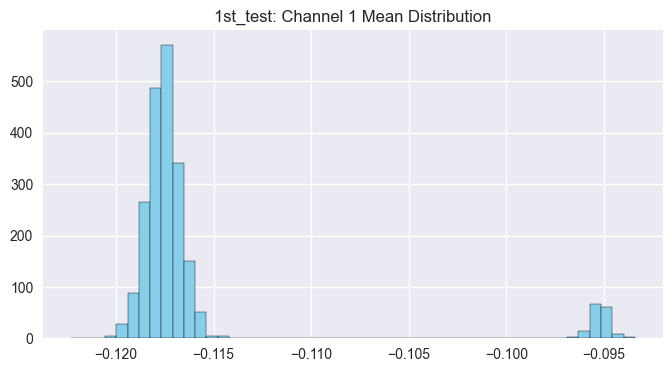

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


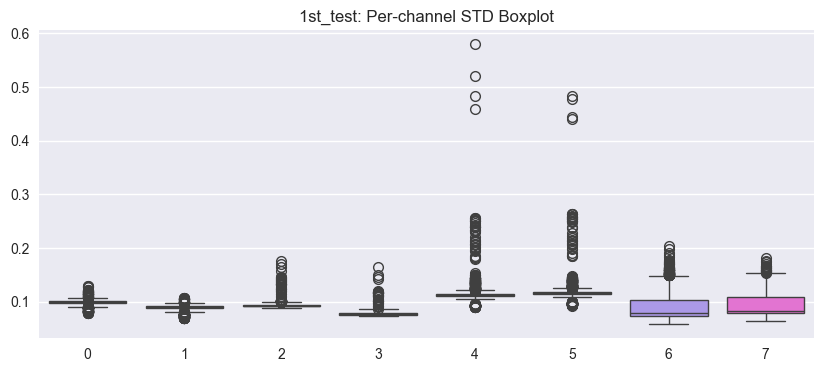

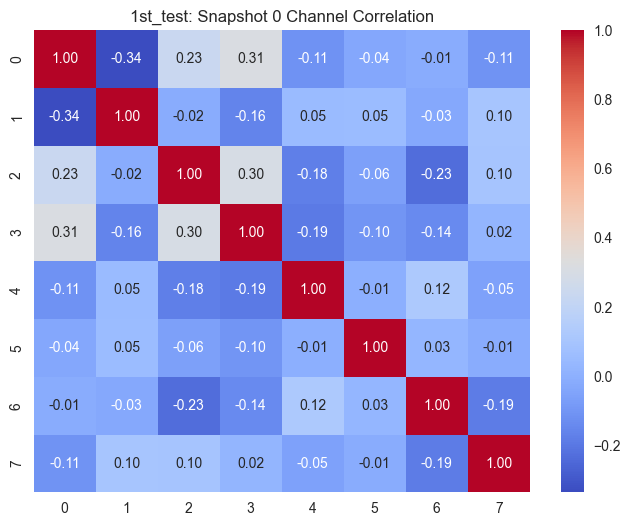

Total missing values across snapshots: 0
Isolation Forest: precision=0.343, recall=0.171, f1=0.228, auc=0.567
LSTM Autoencoder: precision=0.389, recall=0.194, f1=0.259, auc=0.580
Results saved to IMS_Bearing_Dataset\1st_test\1st_test_results.csv

Processing folder: 2nd_test

=== EDA for 2nd_test ===
Number of snapshots: 984
Snapshot lengths: min=20480, max=20480, avg=20480.00


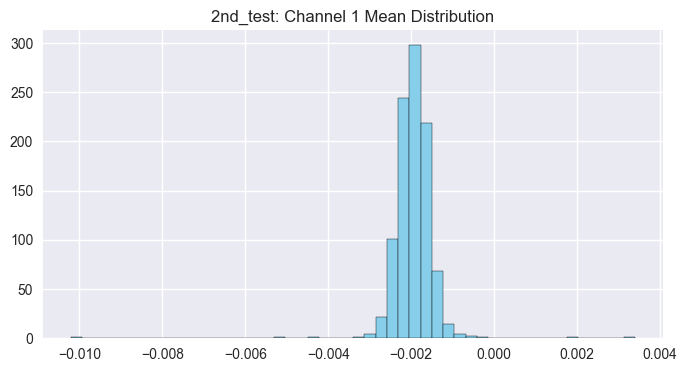

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


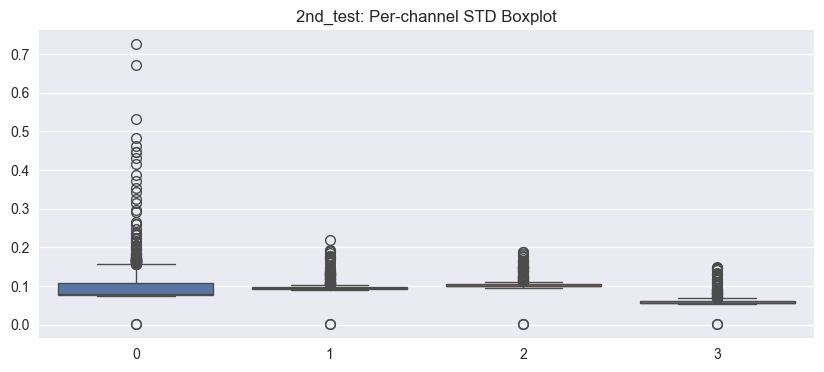

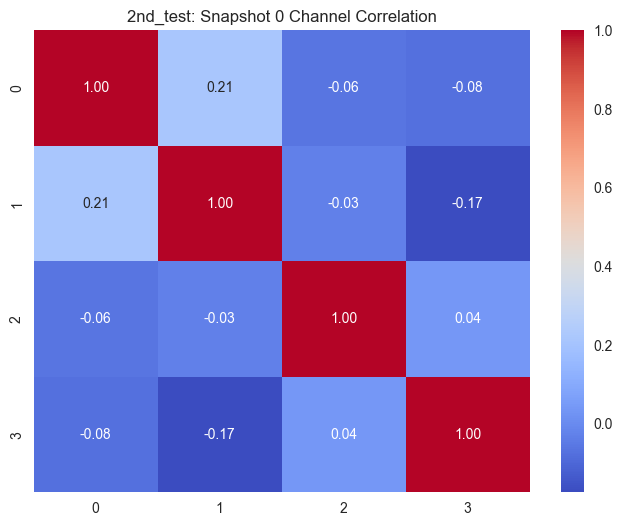

Total missing values across snapshots: 0


C:\Users\Harsha\AppData\Local\Temp\ipykernel_23000\3630457170.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": stats.skew(x),
C:\Users\Harsha\AppData\Local\Temp\ipykernel_23000\3630457170.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": stats.kurtosis(x),
C:\Users\Harsha\AppData\Local\Temp\ipykernel_23000\3630457170.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": stats.skew(x),
C:\Users\Harsha\AppData\Local\Temp\ipykernel_23000\3630457170.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are ne

Isolation Forest: precision=0.980, recall=0.495, f1=0.658, auc=0.747
LSTM Autoencoder: precision=0.920, recall=0.465, f1=0.617, auc=0.730
Results saved to IMS_Bearing_Dataset\2nd_test\2nd_test_results.csv

Processing folder: 3rd_test

=== EDA for 3rd_test ===
Number of snapshots: 255
Snapshot lengths: min=20480, max=20480, avg=20480.00


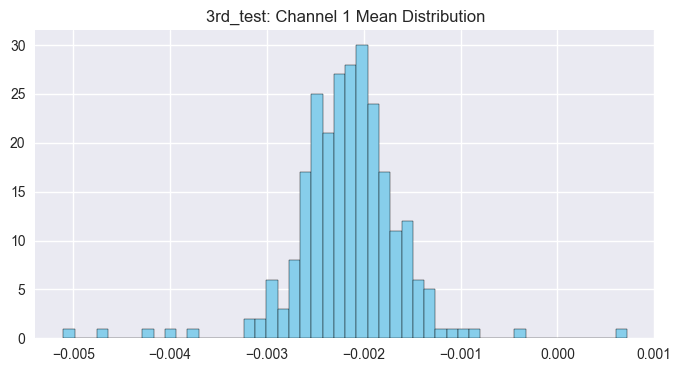

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


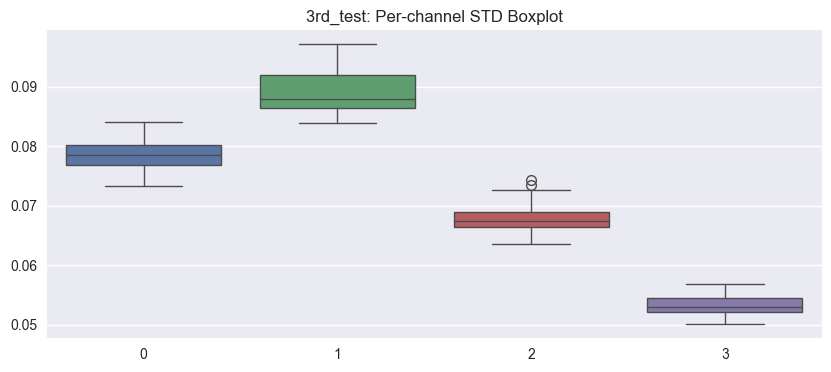

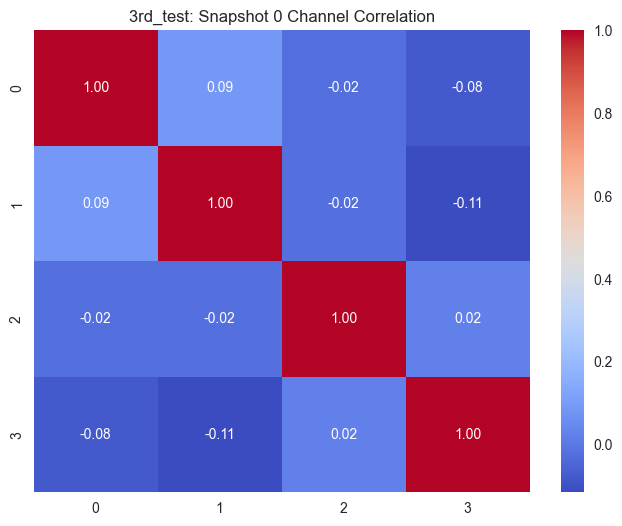

Total missing values across snapshots: 0
Isolation Forest: precision=0.231, recall=0.115, f1=0.154, auc=0.536
LSTM Autoencoder: precision=0.000, recall=0.000, f1=0.000, auc=0.472
Results saved to IMS_Bearing_Dataset\3rd_test\3rd_test_results.csv


In [44]:
# Loop over all test folders
folders = find_test_folders(DATA_ROOT)
for f in folders:
    try:
        run_pipeline_for_folder(f)
    except Exception as e:
        print(f"Error processing folder {f.name}: {e}")


# In-Depth Insight Report: Time Series Anomaly Detection for IoT Sensors

## 1. Project Overview
This project implements an end-to-end machine learning pipeline for detecting anomalies in **multivariate time series sensor data**, focusing on manufacturing equipment monitored by IoT sensors.  
**Goal:** Early identification of equipment failure or maintenance needs by recognizing unusual sensor readings.

---

## 2. Data Loading and Management
- Data sourced from **NASA IMS Bearing Dataset**, organized into multiple test folders.  
- **Snapshot-based organization** ensures uniformity (~20,480 data points per snapshot).  
- **Data validation:** No missing values, consistent snapshot lengths, ensuring high-quality inputs.

---

## 3. Exploratory Data Analysis (EDA)
**Purpose:** Understand data characteristics, quality, and patterns.

### Data Characteristics
- Uniform snapshot lengths; variable number of snapshots across datasets.  
- No missing values detected.

### Statistical Summaries
- Computed **per-snapshot and per-channel statistics** (mean, std deviation).  
- **Histograms** show amplitude distributions, highlighting baseline variability and anomalies.  
- **Boxplots** indicate outlier presence, later treated during feature engineering.

### Sensor Inter-Relationships
- **Correlation heatmaps** reveal dependencies among sensor channels.  
- High correlation → redundant information; low correlation → diverse vibration sources.  
- Guides feature selection and dimensionality reduction.

### Outlier Detection and Treatment
- Outliers identified via **IQR** and **z-score** methods.  
- Outliers capped/clipped to reduce distortion effects, improving model generalization.

### Visual Pattern Discovery
- Time series plots with anomaly labels show evolving trends of bearing degradation.  
- Metrics like mean and variance changes suggest gradual faults or intermittent spikes.  
- Insights inform **heuristic labeling** and model thresholding.

---

## 4. Feature Engineering
**Features extracted from both time and frequency domains:**

### Time-Domain Features
- Mean, RMS, standard deviation, skewness, kurtosis, median  
- Rolling statistics (e.g., moving average, rolling std)

### Frequency-Domain Features
- Spectral centroid, peak frequency, spectral entropy  
- Energy ratios computed via **Welch's method**

**Additional Steps**
- Feature selection guided by bearing vibration domain knowledge.  
- **Robust scaling** applied to stabilize models against noise and outliers.

---

## 5. Labeling Approach
- **Heuristic labeling:** last 10% of snapshots marked as anomalies to approximate degradation onset.  
- Enables **supervised evaluation** in absence of explicit ground-truth labels.

---

## 6. Anomaly Detection Models

### 6.1 Isolation Forest
- **Unsupervised model** detecting statistical outliers.  
- Hyperparameters like **contamination** tuned based on dataset assumptions.

### 6.2 LSTM Autoencoder
- **Recurrent neural network** trained to reconstruct normal sequences.  
- High reconstruction error → anomaly.  
- Captures temporal patterns and nonlinearities better than statistical methods.

---

## 7. Evaluation and Results
**Evaluation Metrics:** Precision, Recall, F1-score, ROC-AUC using heuristic labels.

| Test Folder | Model             | Precision | Recall | F1-score | ROC AUC |
|------------|-----------------|----------|--------|----------|---------|
| 1sttest    | Isolation Forest | 0.34     | 0.17   | 0.23     | 0.57    |
|            | LSTM Autoencoder | 0.39     | 0.19   | 0.26     | 0.58    |
| 2ndtest    | Isolation Forest | 0.98     | 0.50   | 0.66     | 0.75    |
|            | LSTM Autoencoder | 0.92     | 0.47   | 0.62     | 0.73    |
| 3rdtest    | Isolation Forest | 0.23     | 0.11   | 0.15     | 0.54    |
|            | LSTM Autoencoder | 0.00     | 0.00   | 0.00     | 0.47    |

**Key Observations**
- **LSTM Autoencoder** outperforms Isolation Forest in the first two tests, especially in precision and F1-score.  
- Both models struggle on the **3rdtest** dataset due to noise or distribution shifts.  
- **Isolation Forest in 2ndtest:** high precision, moderate recall → detects true anomalies but misses some.  
- ROC AUC scores indicate moderate separability of normal and anomalous states.  
- Visual inspection and domain knowledge remain essential due to heuristic labels.

---

## 8. Implementation Highlights
- Modular **Jupyter notebook** design for flexibility and reproducibility.  
- Robust **error handling and logging** for reliability.  
- Results saved systematically with visualizations for interpretability.

---

## 9. Key Insights
- **Feature engineering** critical for balancing interpretability and model readiness.  
- Deep learning models excel at capturing **complex temporal dependencies**.  
- Realistic labels improve evaluation accuracy and model generalization.  
- **Cross-dataset training** may enhance model robustness.

---

## 10. Future Directions
- Incorporate **true labels** or expert annotations.  
- Extend models with **attention mechanisms** or **ConvLSTM**.  
- Deploy **real-time anomaly detection** with alert systems.  
- Explore **multimodal sensor fusion** for richer fault diagnosis.

---
